In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('nanopore-og.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCTGACCTCGGAATGCGTGGTCTCCATGCGC...
1,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
2,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGGAATGCGGTCTCCATGCGCG...
3,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGCCGACCTCAGAATGCGGTCTCCATGCGCGTT...
4,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAGATGCGGTCACCATGCGCG...
...,...,...
269704,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...,TATCGTGGTATCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...
269705,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...
269706,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...,AATGCAATCCTCCAACCCGAATGACCTGGCGAGGCAGATCAACTTG...
269707,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...,ATCGTGGTATCCCTCCAACCCGAATGACCTGGCGAGGCAGATCAAC...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 269709/269709 [00:03<00:00, 70465.71it/s]


[28819, 32333, 35937, 39281, 42437, 46620, 50189, 53098, 56198, 58637, 61369, 64877, 68495, 70743, 73198, 76713, 79117, 80991, 84050, 86365, 88352, 90504, 93388, 94732, 96981, 99822, 101723, 103101, 104913, 107396, 108758, 110307, 112407, 114293, 115952, 116688, 119154, 120305, 121774, 123666, 125292, 126422, 127579, 129083, 130375, 131540, 132615, 133434, 135269, 136253, 136967, 137646, 138126, 139787, 141127, 141951, 142170, 143068, 144339, 144994, 146209, 145651, 146551, 148315, 149100, 148868, 149812, 150654, 151058, 152271, 152631, 152068, 153084, 153918, 154995, 154498, 155038, 156334, 156694, 156277, 157608, 157433, 157996, 159092, 160003, 158892, 159790, 160877, 160869, 160589, 161221, 161644, 162496, 163489, 163004, 163056, 162951, 164013, 163967, 164405, 164647, 165696, 165921, 165661, 166048, 166215, 152881, 131932, 103895, 71430]


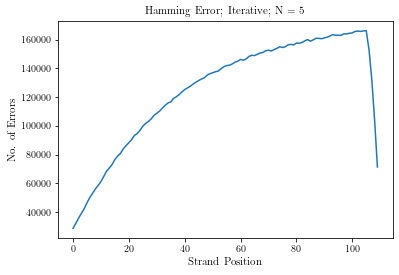

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 269709/269709 [05:14<00:00, 858.05it/s] 


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


CTCTT ->  6
 -> ATAAT 6
 -> CCCCT 6
T -> GCAA 6
CTCGT ->  6
 -> TCATG 6
 -> GGGGA 6
TTTAC ->  6
ATAAG ->  6
CTCTC ->  6
CA -> TTGGT 6
CA -> GTT 6
CCTT -> G 6
TT -> CAGC 6
CTGCC ->  6
AAAC -> GT 6
 -> GTAAT 6
ATAG -> C 6
TTCG -> A 6
G -> TAAC 6
GCGGT ->  6
A -> TGTT 6
GGC -> ATTA 6
CT -> AG 6
 -> TCCCC 6
ATACG ->  6
 -> CGGCC 6
AAAA -> T 6
TTAAG ->  6
GG -> TAAA 6
CTATA ->  6
TTTAT -> CGGC 6
AT -> GGG 6
T -> CGAA 6
TGTG -> C 6
TG -> CAC 6
TGTG -> CA 6
GG -> TCA 6
GG -> CCA 6
 -> CCTTT 6
CACAA ->  6
CCCGG -> A 6
GTAAT ->  6
T -> CGCG 6
AAAAT -> C 6
CTAAG ->  6
T -> CCAGC 6
GG -> ACAT 6
T -> CCAG 6
 -> TTAAT 6
TT -> AGCA 6
 -> AAATC 6
CTAA -> G 6
TGTCT ->  6
A -> TTCG 6
ATAAA ->  6
CCCGT ->  6
GTGT -> AA 6
C -> TTTAT 6
GG -> ATTA 6
TC -> GA 6
 -> CGTC 6
G -> ACAC 6
ATT -> CGC 6
 -> GCTTT 6
 -> AGGCA 6
TT -> AAG 6
GATT -> C 6
GCC -> AAA 6
GTCT -> A 6
GTCTG ->  6
ACTTG ->  6
 -> AAGCC 6
ATTGC ->  6
GCC -> TAT 6
TGGCC ->  6
G -> AACT 6
TTTA -> CG 6
CACC -> T 6
 -> AAGGA 6
 -> TGGGG 6
CCC -> 

TGT -> C @ 40 6
TT -> G @ 66 6
TTT ->  @ 80 6
 -> CCA @ 94 6
 -> CGC @ 39 6
TT -> G @ 92 6
TGC ->  @ 99 6
TGT -> C @ 44 6
 -> ATA @ 53 6
TTT ->  @ 78 6
TTT ->  @ 79 6
TGC ->  @ 98 6
TGT -> C @ 5 6
 -> AGG @ 46 6
TA -> CC @ 2 6
T -> GCC @ 3 6
 -> CGC @ 27 6
 -> AAA @ 40 6
 -> CCA @ 6 6
TAC ->  @ 26 6
TG -> A @ 49 6
T -> GCC @ 62 6
TG -> A @ 4 6
 -> CAA @ 88 6
TA -> C @ 16 6
TA -> C @ 18 6
TA -> C @ 19 6
 -> ACC @ 91 6
 -> CAA @ 97 6
TA -> C @ 22 6
TA -> C @ 95 6
TA -> C @ 92 6
TA -> C @ 13 6
TG -> A @ 3 6
TA -> C @ 68 6
 -> CAG @ 69 6
TA -> C @ 33 6
TA -> C @ 5 6
 -> CAA @ 95 6
 -> AAA @ 45 6
TTT ->  @ 24 6
 -> AAA @ 5 6
T -> GCC @ 61 6
TGC ->  @ 70 6
TGT -> C @ 52 6
T -> GCC @ 78 6
TA -> C @ 10 6
TAC ->  @ 31 6
 -> CGG @ 64 6
T -> GCC @ 37 6
TGC ->  @ 58 6
TG -> CA @ 2 6
T -> GCC @ 4 6
T -> GCC @ 40 6
TGC ->  @ 6 6
TGC ->  @ 92 6
 -> AAA @ 64 6
 -> CAA @ 86 6
 -> CGC @ 31 6
TGT -> A @ 7 6
 -> AAA @ 68 6
TAA -> G @ 73 6
TCG ->  @ 25 6
TGC ->  @ 88 6
 -> CAT @ 0 6
TGC ->  @ 66 6
TG -> A 

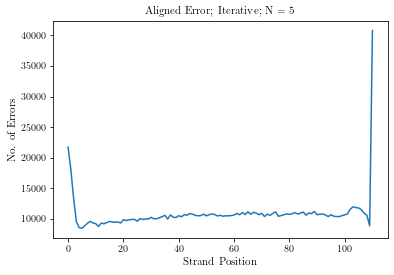

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [27]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]

print(sum(counts_no_pos))
print(sum(counts_no_pos[:10]) / sum(counts_no_pos))

print(max_10_keys)
print(sub_keys)


1205656
8.294239816332354e-06
['T -> C', 'C -> T', 'A -> _', '_ -> A', '_ -> C', '_ -> G', '_ -> T', 'T -> _', 'C -> _', 'G -> _']
['TTTTTTTT -> C', 'CCC -> AAAATT', 'TGGGGT -> CAA', 'TGGGGTG -> A', 'CCATTG -> _', 'CCATTCT -> _', 'CCATTCGTG -> _', 'CCATTAT -> _', 'CCATTACT -> _', 'CCATT -> _', 'CCATG -> _', 'CCATAC -> _', 'CCATA -> _', 'CCAT -> GG', 'CCC -> AAG', 'CCAGTTG -> _', 'CCAGGC -> T', 'CCAGG -> T', 'CCAGCT -> _', 'CCAGCG -> T', 'CCAGCCT -> _', 'CCAGCCC -> _', 'CCAGC -> TT', 'CCAGC -> T', 'CCAGACT -> _', 'CCAGA -> T', 'CCAG -> TT', 'CCACT -> _', 'CCACGTCGGGA -> _', 'CCAGT -> _', 'CCACG -> TT', 'TGGGGGG -> CAAA', 'CCC -> AGGAA', 'CCCAC -> T', 'CCCAAG -> T', 'CCCAAG -> _', 'CCCAACA -> _', 'CCCAA -> TGGT', 'CCCAA -> G', 'CCCA -> TTG', 'CCCA -> GT', 'CCCA -> GG', 'TGGGG -> AA', 'CCC -> TTTGA', 'TGGGG -> AAA', 'CCC -> TGG', 'CCC -> AATTT', 'TGGGG -> CAA', 'TGGGGC -> _', 'TGGGGCC -> AA', 'CCC -> GTTTT', 'CCC -> GTT', 'CCC -> GGTT', 'CCC -> GGGTTATT', 'CCC -> GGG', 'CCC -> GA', 'TGGGG

G -> _
[0, 1137, 1005, 607, 619, 719, 680, 810, 799, 739, 611, 608, 689, 680, 696, 854, 792, 780, 696, 691, 778, 777, 825, 821, 756, 713, 749, 790, 728, 827, 806, 752, 728, 793, 829, 822, 789, 856, 860, 816, 830, 860, 793, 793, 845, 730, 805, 781, 794, 883, 863, 819, 922, 796, 863, 849, 800, 791, 789, 777, 778, 882, 764, 800, 835, 859, 782, 860, 855, 828, 774, 780, 784, 802, 804, 911, 858, 815, 815, 720, 915, 776, 833, 823, 900, 828, 812, 820, 779, 821, 865, 832, 826, 728, 835, 722, 753, 775, 822, 852, 855, 783, 799, 844, 808, 739, 707, 722, 704, 816, 6603]


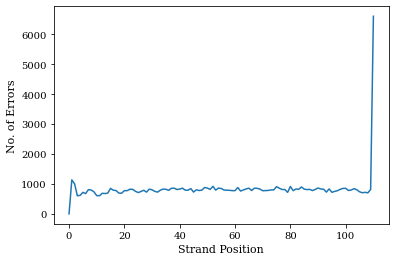

C -> _
[0, 5282, 969, 522, 682, 687, 585, 690, 669, 711, 730, 777, 732, 734, 770, 712, 736, 725, 793, 677, 738, 716, 776, 767, 771, 859, 760, 821, 736, 737, 805, 756, 815, 738, 756, 763, 740, 832, 771, 814, 820, 782, 937, 814, 863, 896, 822, 799, 777, 763, 881, 847, 772, 871, 794, 880, 874, 827, 898, 843, 867, 810, 843, 786, 789, 869, 807, 903, 915, 765, 786, 744, 861, 852, 876, 840, 752, 812, 807, 912, 838, 781, 914, 792, 780, 780, 749, 853, 817, 847, 738, 790, 759, 856, 811, 872, 789, 775, 790, 818, 813, 821, 937, 914, 936, 922, 881, 764, 864, 877, 1346]


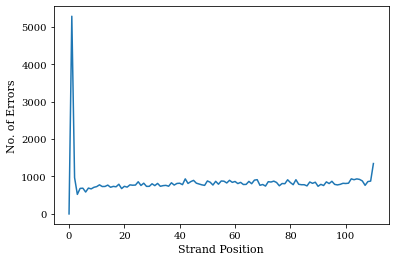

T -> _
[0, 1901, 503, 733, 447, 443, 531, 520, 571, 546, 564, 445, 550, 571, 628, 572, 593, 633, 572, 611, 559, 653, 572, 632, 658, 529, 617, 586, 616, 633, 672, 578, 632, 591, 591, 695, 627, 753, 648, 560, 624, 671, 652, 566, 747, 613, 570, 669, 644, 648, 629, 717, 706, 521, 609, 680, 647, 658, 661, 558, 646, 673, 672, 664, 603, 704, 593, 579, 693, 693, 675, 656, 665, 573, 645, 785, 630, 646, 617, 681, 661, 561, 639, 730, 647, 742, 631, 665, 660, 787, 641, 659, 668, 731, 585, 714, 639, 712, 589, 579, 576, 561, 618, 767, 755, 773, 617, 714, 697, 677, 1220]


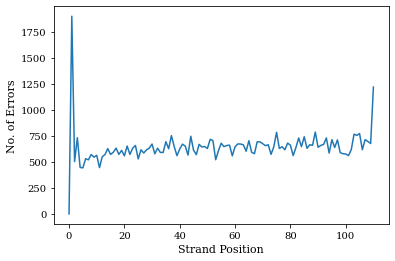

_ -> T
[5536, 398, 691, 455, 502, 467, 440, 474, 524, 554, 589, 537, 540, 542, 544, 537, 523, 537, 532, 564, 553, 573, 557, 507, 548, 508, 542, 565, 604, 614, 566, 607, 562, 628, 614, 598, 589, 606, 542, 539, 617, 579, 675, 637, 565, 585, 591, 624, 623, 615, 609, 609, 591, 635, 573, 576, 577, 569, 591, 571, 623, 653, 624, 589, 607, 648, 605, 648, 571, 592, 661, 575, 578, 588, 613, 607, 552, 543, 626, 603, 563, 628, 622, 588, 574, 620, 592, 573, 545, 584, 553, 549, 562, 534, 526, 579, 568, 580, 594, 688, 684, 837, 890, 872, 628, 544, 535, 540, 566, 457, 1171]


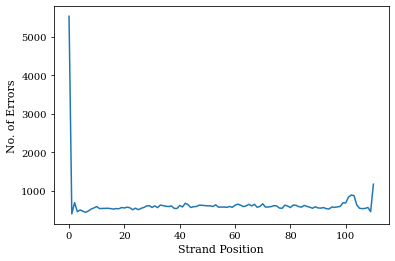

_ -> G
[559, 699, 519, 421, 451, 441, 491, 464, 487, 539, 532, 520, 546, 462, 553, 532, 512, 494, 548, 556, 533, 546, 533, 535, 545, 569, 507, 532, 555, 578, 553, 559, 545, 590, 578, 590, 568, 576, 568, 568, 545, 537, 582, 558, 588, 603, 537, 581, 587, 624, 620, 585, 612, 619, 585, 572, 582, 506, 579, 592, 602, 570, 605, 630, 594, 591, 631, 656, 621, 565, 594, 575, 580, 591, 621, 616, 592, 561, 614, 621, 638, 614, 633, 552, 595, 560, 570, 632, 632, 589, 609, 575, 617, 633, 626, 593, 590, 537, 488, 471, 513, 552, 651, 727, 772, 682, 659, 547, 425, 806, 4433]


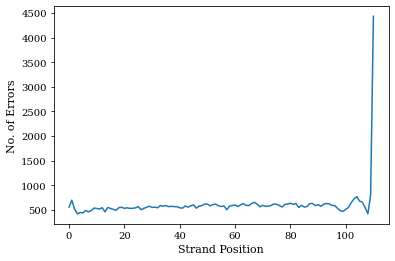

_ -> C
[4997, 790, 508, 547, 398, 474, 513, 528, 525, 534, 531, 481, 544, 520, 501, 538, 522, 504, 534, 511, 585, 552, 572, 534, 542, 538, 568, 538, 566, 529, 564, 580, 570, 518, 579, 595, 560, 577, 542, 556, 605, 560, 615, 616, 578, 590, 586, 530, 607, 613, 532, 563, 547, 601, 545, 570, 604, 597, 530, 558, 610, 625, 585, 634, 584, 611, 544, 596, 562, 568, 597, 550, 586, 553, 627, 555, 562, 562, 640, 577, 541, 631, 618, 513, 587, 536, 547, 580, 606, 574, 574, 555, 568, 567, 583, 563, 546, 505, 577, 529, 504, 491, 524, 448, 512, 644, 573, 604, 920, 673, 773]


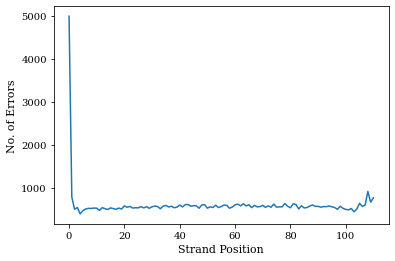

_ -> A
[925, 406, 425, 442, 415, 417, 411, 471, 444, 457, 389, 439, 466, 448, 433, 489, 515, 475, 467, 449, 502, 448, 461, 498, 452, 449, 532, 473, 472, 481, 495, 478, 507, 486, 500, 511, 486, 486, 468, 490, 497, 492, 539, 500, 546, 507, 501, 500, 509, 435, 470, 509, 536, 542, 529, 464, 515, 503, 485, 482, 497, 530, 513, 524, 472, 513, 523, 488, 528, 519, 536, 504, 464, 477, 529, 535, 465, 496, 512, 523, 508, 521, 506, 532, 542, 517, 507, 534, 559, 549, 541, 493, 508, 523, 479, 507, 462, 465, 524, 517, 522, 564, 555, 479, 471, 504, 456, 540, 799, 426, 4175]


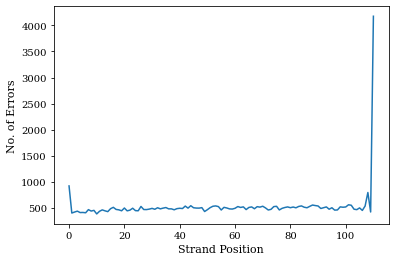

A -> _
[0, 762, 503, 570, 455, 429, 567, 478, 585, 426, 490, 427, 545, 535, 472, 507, 536, 483, 488, 483, 547, 498, 456, 468, 523, 448, 507, 483, 487, 531, 571, 512, 533, 566, 529, 490, 491, 499, 449, 533, 502, 539, 430, 507, 563, 538, 576, 540, 484, 534, 511, 559, 424, 511, 530, 554, 478, 507, 463, 562, 564, 516, 470, 585, 500, 569, 496, 512, 535, 496, 472, 549, 500, 571, 521, 543, 506, 583, 544, 602, 442, 485, 510, 544, 537, 542, 506, 588, 556, 571, 492, 601, 613, 525, 553, 534, 505, 510, 569, 552, 492, 564, 675, 560, 643, 591, 627, 556, 497, 537, 1557]


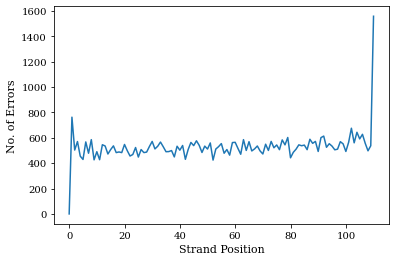

C -> T
[0, 1482, 1013, 265, 342, 439, 329, 357, 381, 456, 411, 412, 424, 445, 428, 426, 423, 415, 476, 398, 433, 383, 435, 452, 426, 436, 477, 426, 397, 468, 404, 434, 453, 426, 455, 423, 435, 445, 441, 478, 461, 402, 425, 500, 445, 493, 533, 434, 442, 474, 525, 438, 498, 511, 410, 467, 450, 463, 486, 519, 437, 461, 480, 450, 471, 437, 498, 517, 466, 425, 443, 436, 496, 453, 494, 431, 375, 439, 451, 458, 431, 451, 464, 422, 469, 464, 440, 443, 416, 402, 436, 359, 385, 326, 367, 423, 379, 401, 443, 532, 668, 834, 862, 753, 673, 554, 395, 407, 382, 205, 918]


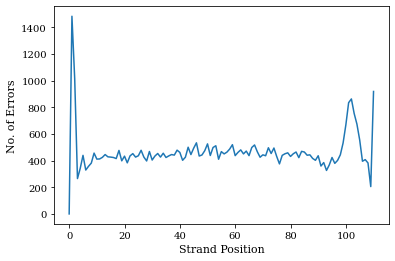

T -> C
[0, 308, 345, 486, 369, 330, 418, 431, 383, 305, 408, 282, 412, 414, 371, 391, 433, 396, 400, 426, 417, 429, 381, 433, 466, 377, 477, 440, 417, 403, 431, 419, 417, 443, 427, 454, 417, 450, 463, 359, 451, 406, 450, 457, 386, 490, 428, 482, 418, 424, 377, 444, 472, 361, 469, 422, 485, 438, 472, 464, 416, 529, 444, 500, 451, 531, 431, 489, 485, 460, 520, 405, 541, 536, 449, 500, 452, 507, 407, 497, 461, 441, 502, 482, 530, 522, 484, 484, 503, 535, 541, 522, 492, 572, 485, 464, 490, 402, 345, 277, 228, 217, 231, 303, 360, 521, 668, 571, 485, 345, 449]


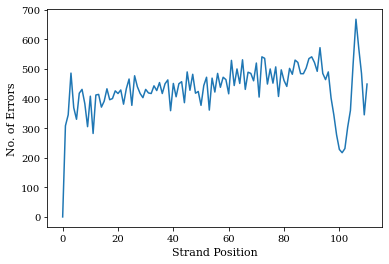

In [28]:
i = 0
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    print(key)
    print(pos_map[key])

    f = plt.figure()
    plt.plot(range(strand_len + 1), pos_map[key])
    plt.xlabel(r'Strand Position', fontsize=11)
    plt.ylabel(r'No. of Errors', fontsize=11)
    plt.show()
    f.savefig(f'{key}second-order-skew.pdf', bbox_inches='tight')


In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)